In [1]:
#Set different parameter choices
sigma = [.02, .04, .06]
b = [.04, .06]
t = [1/12]
a = [1, .5, .25]

In [2]:
import itertools
import numpy as np
params = np.array(list(itertools.product(*(sigma, b, t, a))))
print(params)

[[0.02       0.04       0.08333333 1.        ]
 [0.02       0.04       0.08333333 0.5       ]
 [0.02       0.04       0.08333333 0.25      ]
 [0.02       0.06       0.08333333 1.        ]
 [0.02       0.06       0.08333333 0.5       ]
 [0.02       0.06       0.08333333 0.25      ]
 [0.04       0.04       0.08333333 1.        ]
 [0.04       0.04       0.08333333 0.5       ]
 [0.04       0.04       0.08333333 0.25      ]
 [0.04       0.06       0.08333333 1.        ]
 [0.04       0.06       0.08333333 0.5       ]
 [0.04       0.06       0.08333333 0.25      ]
 [0.06       0.04       0.08333333 1.        ]
 [0.06       0.04       0.08333333 0.5       ]
 [0.06       0.04       0.08333333 0.25      ]
 [0.06       0.06       0.08333333 1.        ]
 [0.06       0.06       0.08333333 0.5       ]
 [0.06       0.06       0.08333333 0.25      ]]


In [3]:
sigma = list(params[:,0])
b = list(params[:,1])
t = list(params[:,2])
a = list(params[:,3])

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

#Set an initial interest rate
initial_state = {'r': .08}


#Basic vasicek rate change model
def rate_change(r, a=.5, b=.06, sigma=.04, t=1/12):
    delta = a* (b-r) * t + t ** .5 * sigma * t ** .5 * norm.ppf(np.random.rand())
    return delta + r


#Policy for updating
def vasicek_policy(_params, substep, sH, s):
    r = rate_change(s['r'], _params['a'], _params['b'], _params['sigma'], _params['t'])
    return {'r': r}

#Simple state update
def update_rate(_params, substep, sH, s, _input):
    return ('r', _input['r'])

#Partial updates
PSUBs = [
    {
        "policies": {
            "rate_policy": vasicek_policy,
        },
        "variables": {
            "r": update_rate,
        }
    }
]

#Set simulation parameters

#The M parameter will let us test different combinations of parameters
sim_config_dict = {
    'T': range(360),
    'N': 100,
"M": {'a': a, 'b':b, 'sigma':sigma, 't':t}}

c = config_sim(sim_config_dict)


exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)


exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 18
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 4, 100, 1)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2

Total execution time: 106.98s


In [5]:
mu = result.groupby(['timestep', 'simulation'])['r'].mean().unstack()
print(mu)

simulation        0         1         2         3         4         5   \
timestep                                                                 
0           0.080000  0.080000  0.080000  0.080000  0.080000  0.080000   
1           0.076739  0.078472  0.079104  0.078409  0.078772  0.079449   
2           0.073450  0.076848  0.078160  0.077084  0.077869  0.079174   
3           0.070918  0.075291  0.077332  0.075786  0.077325  0.078988   
4           0.068281  0.073735  0.076171  0.074554  0.076648  0.078884   
...              ...       ...       ...       ...       ...       ...   
356         0.039934  0.039547  0.040503  0.060320  0.060061  0.060807   
357         0.039873  0.039559  0.040439  0.060397  0.060303  0.060908   
358         0.040223  0.039776  0.040462  0.060302  0.060285  0.060743   
359         0.040136  0.039825  0.040317  0.060359  0.060065  0.061030   
360         0.040279  0.039883  0.040479  0.060251  0.060244  0.060753   

simulation        6         7        

In [13]:
params = pd.DataFrame(list(zip(sigma, b, t, a)), columns = ['sigma', 'b', 't', 'a'])

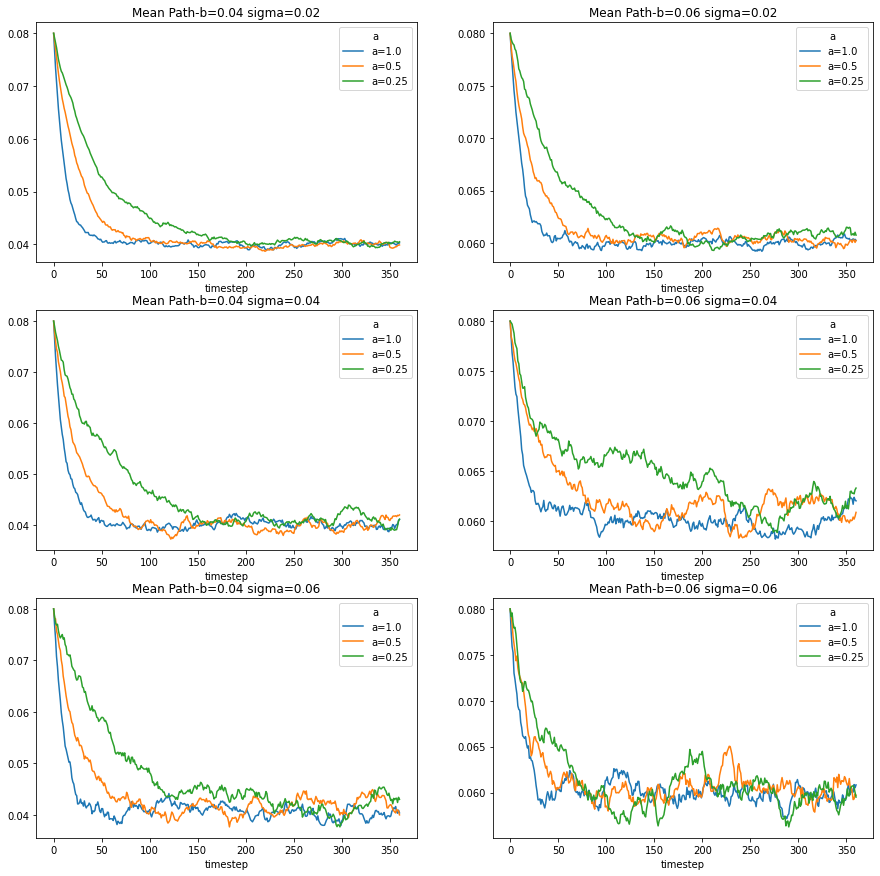

In [34]:
fig, ax = plt.subplots(nrows=len(params['sigma'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, sigma in enumerate(params['sigma'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Mean Path-b={} sigma={}".format(b,sigma))
        ts = mu[params[(params['sigma'] == sigma) & (params['b'] == b)].index]
        ts.columns = params[(params['sigma'] == sigma) & (params['b'] == b)]['a']
        ts.columns = "a="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()

In [35]:
std_cross_section = result.groupby(['timestep', 'simulation'])['r'].std().unstack()
print(std_cross_section)

simulation        0         1         2         3         4         5   \
timestep                                                                 
0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1           0.001610  0.001391  0.001775  0.001589  0.001488  0.001753   
2           0.002248  0.002290  0.002464  0.002227  0.002155  0.002623   
3           0.002979  0.002805  0.002923  0.002857  0.002875  0.003098   
4           0.003246  0.002948  0.003281  0.003035  0.003037  0.003291   
...              ...       ...       ...       ...       ...       ...   
356         0.003542  0.005389  0.007800  0.004554  0.006266  0.008111   
357         0.003506  0.005476  0.007731  0.004557  0.006307  0.008058   
358         0.003863  0.005574  0.007854  0.004540  0.006251  0.008084   
359         0.003771  0.005679  0.007591  0.004560  0.006104  0.007985   
360         0.003747  0.005722  0.007559  0.004773  0.006178  0.007721   

simulation        6         7        

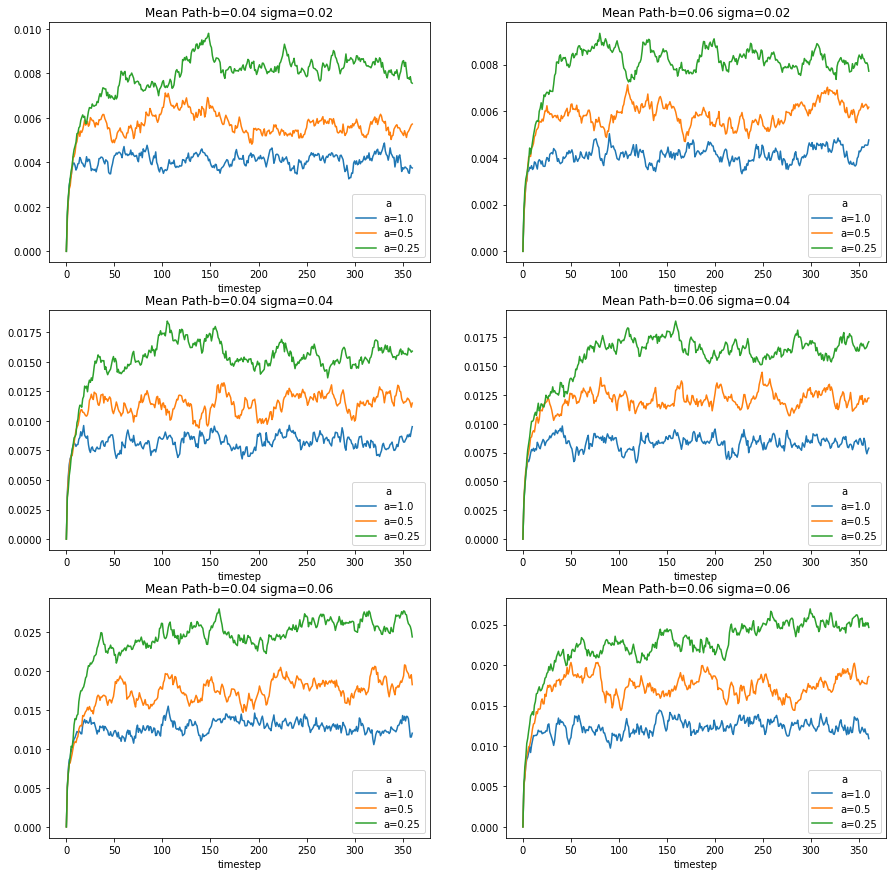

In [36]:
fig, ax = plt.subplots(nrows=len(params['sigma'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, sigma in enumerate(params['sigma'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Mean Path-b={} sigma={}".format(b,sigma))
        ts = std_cross_section[params[(params['sigma'] == sigma) & (params['b'] == b)].index]
        ts.columns = params[(params['sigma'] == sigma) & (params['b'] == b)]['a']
        ts.columns = "a="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()

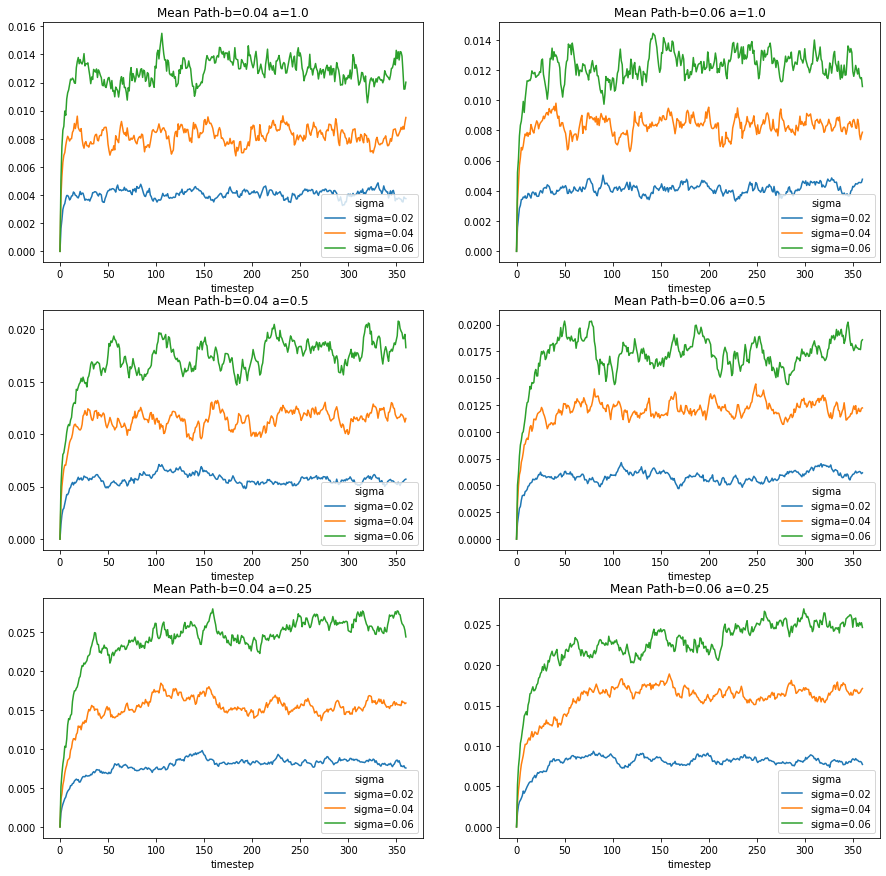

In [37]:
fig, ax = plt.subplots(nrows=len(params['a'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, a in enumerate(params['a'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Mean Path-b={} a={}".format(b,a))
        ts = std_cross_section[params[(params['a'] == a) & (params['b'] == b)].index]
        ts.columns = params[(params['a'] == a) & (params['b'] == b)]['sigma']
        ts.columns = "sigma="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()